In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from gensim.models import Word2Vec

In [2]:
# read relevant csv files
notes_orig = pd.read_csv('./NOTEEVENTS.csv', usecols=['SUBJECT_ID','HADM_ID','TEXT'], dtype={'TEXT':str}, encoding ='utf-8')
patients = pd.read_csv('./PATIENTS.csv', usecols=['SUBJECT_ID','DOB','DOD','GENDER'], encoding = 'utf-8')
ICD = pd.read_csv('./D_ICD_DIAGNOSES.csv', usecols=['ICD9_CODE','SHORT_TITLE','LONG_TITLE'], encoding = 'utf-8')
diagnosis = pd.read_csv('./DIAGNOSES_ICD.csv', usecols=['SUBJECT_ID','HADM_ID','ICD9_CODE'], encoding ='utf-8')
admission = pd.read_csv('./ADMISSIONS.csv', usecols=['SUBJECT_ID','HADM_ID','ADMISSION_TYPE','INSURANCE','LANGUAGE','RELIGION','MARITAL_STATUS','ETHNICITY','DIAGNOSIS'], encoding ='utf-8')

https://www.ncbi.nlm.nih.gov/books/NBK367628/table/sb202.t4/?report=objectonly these are the relevant ICD9 codes

# Preprocessing

In [3]:
# relevant ICD9 codes
opioid_abuse_codes = ['30400','30401','30402','30403','30470','30471','30472','30473','30550','30551','30552','30553','96500','96509']
alcohol_abuse_codes = ['30300','30301','30302','30303','30390','30391','30392','30393','30500','30501','30502','30503','E8600']
amphetamine_abuse_codes = ['30440','30441','30442','30443','30570','30571','30572','30573']
cannabis_abuse_codes = ['30430','30431','30432','30433','30520','30521','30522','30523']
cocaine_abuse_codes = ['30420','30421','30422','30423','30560','30561','30562','30563','9685','E9385']
halluc_abuse_codes = ['30450','30451','30452','30453','30530','30531','30532','30533','9696','E8541','E9396']
barb_abuse_codes = ['30410','30411','30412','30413','30540','30541','30542','30543']
other_abuse_codes = ['30460','30461','30462','30463','30480','30481','30482','30483','30490','30491','30492','30493','30590','30591','30592','30593']
#drug_withdrawal_code = ['2920']

In [4]:
# create dataframes for relevant drug abuse categories
opiods_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(opioid_abuse_codes)].reset_index(drop = True)
alcohol_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(alcohol_abuse_codes)].reset_index(drop = True)
amphetamine_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(amphetamine_abuse_codes)].reset_index(drop = True)
cannabis_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(cannabis_abuse_codes)].reset_index(drop = True)
cocaine_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(cocaine_abuse_codes)].reset_index(drop = True)
halluc_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(halluc_abuse_codes)].reset_index(drop = True)
barb_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(barb_abuse_codes)].reset_index(drop = True)
other_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(other_abuse_codes)].reset_index(drop = True)
#withdrawal_df = diagnosis.loc[diagnosis.ICD9_CODE.isin(drug_withdrawal_code)].reset_index(drop = True)

In [5]:
opiods_df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,64,172056,30400
1,78,100536,96500
2,78,100536,30401
3,109,158995,96509
4,303,103013,96509


In [6]:
# create extra columns signifying classes
list_df = [opiods_df,alcohol_df,amphetamine_df,cannabis_df,cocaine_df,halluc_df,barb_df,other_df]
opiods_df['Opioid_Abuse'] = 1
alcohol_df['Alc_Abuse'] = 1
amphetamine_df['Amphet_Abuse'] = 1
cannabis_df['Cannabis_Abuse'] = 1
cocaine_df['Cocaine_Abuse'] = 1
halluc_df['Halluc_Abuse'] = 1
barb_df['Barb_Abuse'] = 1
other_df['Other_Abuse'] = 1
#withdrawal_df['Withdrawal'] = 1

In [7]:
# drop ICD9 columns in all dataframes
for i in list_df:
    i.drop(columns = 'ICD9_CODE', inplace = True)

In [8]:
# get statistics for dataframes
stats = []
for j in list_df:
    stats.append(len(j))
    print(j.shape)

(877, 3)
(3657, 3)
(40, 3)
(166, 3)
(681, 3)
(18, 3)
(119, 3)
(310, 3)


In [9]:
stats

[877, 3657, 40, 166, 681, 18, 119, 310]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

<BarContainer object of 8 artists>

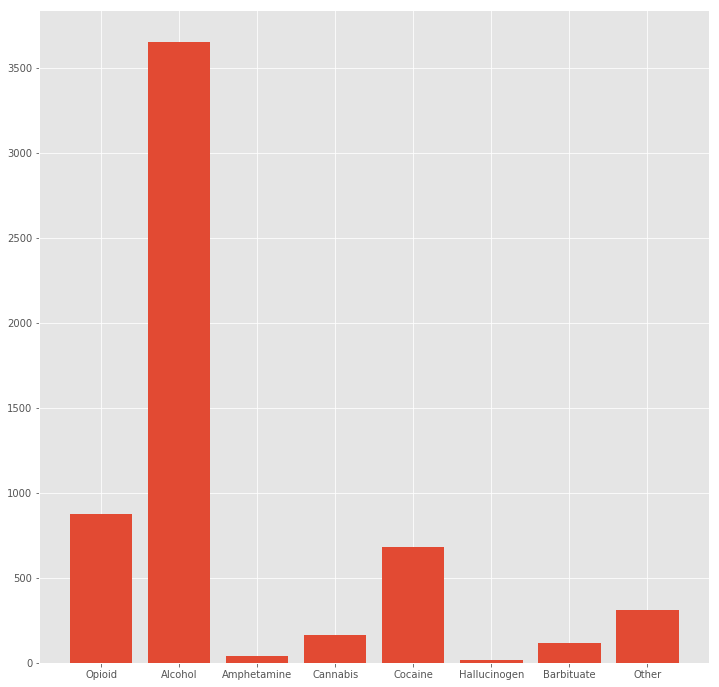

In [11]:
plt.figure(figsize=(12,12))
plt.bar(['Opioid','Alcohol','Amphetamine','Cannabis','Cocaine','Hallucinogen','Barbituate','Other'], height = stats )

In [12]:
# create stop words and snowball stemmer
stop_words = set(nltk.corpus.stopwords.words('english'))
snow = nltk.SnowballStemmer('english')

In [13]:
# function to tokenize/normalize text
def tokenize_mimic(text):
    x = text.lower() # make lowercase
    x = re.sub('[^a-z \n\./:]', '', x) # remove non-numbers or letters
    x = re.sub('[\n/]', ' ', x)  # replace \n and / with space
    x = re.sub('.*chief complaint:','',x)
    x = re.sub('followup instructions: .*', '',x)
    x = re.sub('[:\.]', ' ', x)
    x = re.sub(' [a-z]{1} ', ' ', x)
    x = re.sub(' [a-z]{2} ', ' ', x)
    x = re.sub(' [^aeiou]* ', ' ', x)
    x = re.sub(' +', ' ', x)
    for i in list(stop_words): # remove stop words
        x = x.replace(' ' + str(i) + ' ',' ')
    x = nltk.word_tokenize(x)
    for i,k in enumerate(x):
        x[i] = snow.stem(k)   
    return x

In [14]:
# drop duplicated subject/hospital admission notes (I want the first note from each hospital admission)
notes_orig.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], inplace = True)

In [15]:
# create notes dataframes
notes_opioid = notes_orig.merge(opiods_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_alcohol = notes_orig.merge(alcohol_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_amphetamine = notes_orig.merge(amphetamine_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_cannabis = notes_orig.merge(cannabis_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_cocaine = notes_orig.merge(cocaine_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_halluc = notes_orig.merge(halluc_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_barb = notes_orig.merge(barb_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
notes_other = notes_orig.merge(other_df, how='right', on = ['SUBJECT_ID','HADM_ID'])
#notes_withdrawal = notes_orig.merge(withdrawal_df, how='right', on = ['SUBJECT_ID','HADM_ID'])

In [16]:
list_notes_df = [notes_opioid, notes_alcohol, notes_amphetamine, notes_cannabis, notes_cocaine, notes_halluc, notes_barb, notes_other]

In [17]:
# drop nas, drop duplicates, and tokenize clinical notes
for k in list_notes_df:
    k.dropna(axis = 0, inplace = True)
    k.drop_duplicates(inplace=True) # subset?
    k.TEXT = k.TEXT.apply(tokenize_mimic)
    k.TEXT = k.TEXT.apply(lambda x: ' '.join(x))

In [18]:
# merge dataframes
notes_all = notes_opioid
for z in list_notes_df:
    if (z is not notes_opioid):
        notes_all = notes_all.merge(z, how = 'outer', on = ['SUBJECT_ID','HADM_ID', 'TEXT']).fillna(0)

In [19]:
# shuffle
notes_all = notes_all.sample(frac=1).reset_index(drop = True)

In [20]:
notes_all.shape

(4733, 11)

In [21]:
notes_all.head()

,SUBJECT_ID,HADM_ID,TEXT,Opioid_Abuse,Alc_Abuse,Amphet_Abuse,Cannabis_Abuse,Cocaine_Abuse,Halluc_Abuse,Barb_Abuse,Other_Abuse
0,4187,115464.0,esld secondari hep cirrhosi major surgic invas...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67740,106809.0,bleed major surgic invas procedur placement hi...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32441,159470.0,alcohol intox suicid ideat alcohol ketoacidosi...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55801,165940.0,neck pain major surgic invas procedur left nec...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,31476,150455.0,contact info major surgic invas procedur cereb...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#notes_all.to_pickle('notes_final')

In [23]:
notes_all.columns

Index(['SUBJECT_ID', 'HADM_ID', 'TEXT', 'Opioid_Abuse', 'Alc_Abuse',
       'Amphet_Abuse', 'Cannabis_Abuse', 'Cocaine_Abuse', 'Halluc_Abuse',
       'Barb_Abuse', 'Other_Abuse'],
      dtype='object')

# Correlations Among Diagnoses

In [24]:
notes_df = pd.read_pickle('notes_final')

In [25]:
len(notes_df)

4733

In [26]:
no_drugs = notes_orig.loc[~notes_orig.SUBJECT_ID.isin(notes_df.SUBJECT_ID)].sample(frac = 0.0027)

In [27]:
no_drugs.dropna(axis = 0, inplace = True)
no_drugs.drop_duplicates(inplace=True) # subset?
no_drugs.TEXT = no_drugs.TEXT.apply(tokenize_mimic)
no_drugs.TEXT = no_drugs.TEXT.apply(lambda x: ' '.join(x))

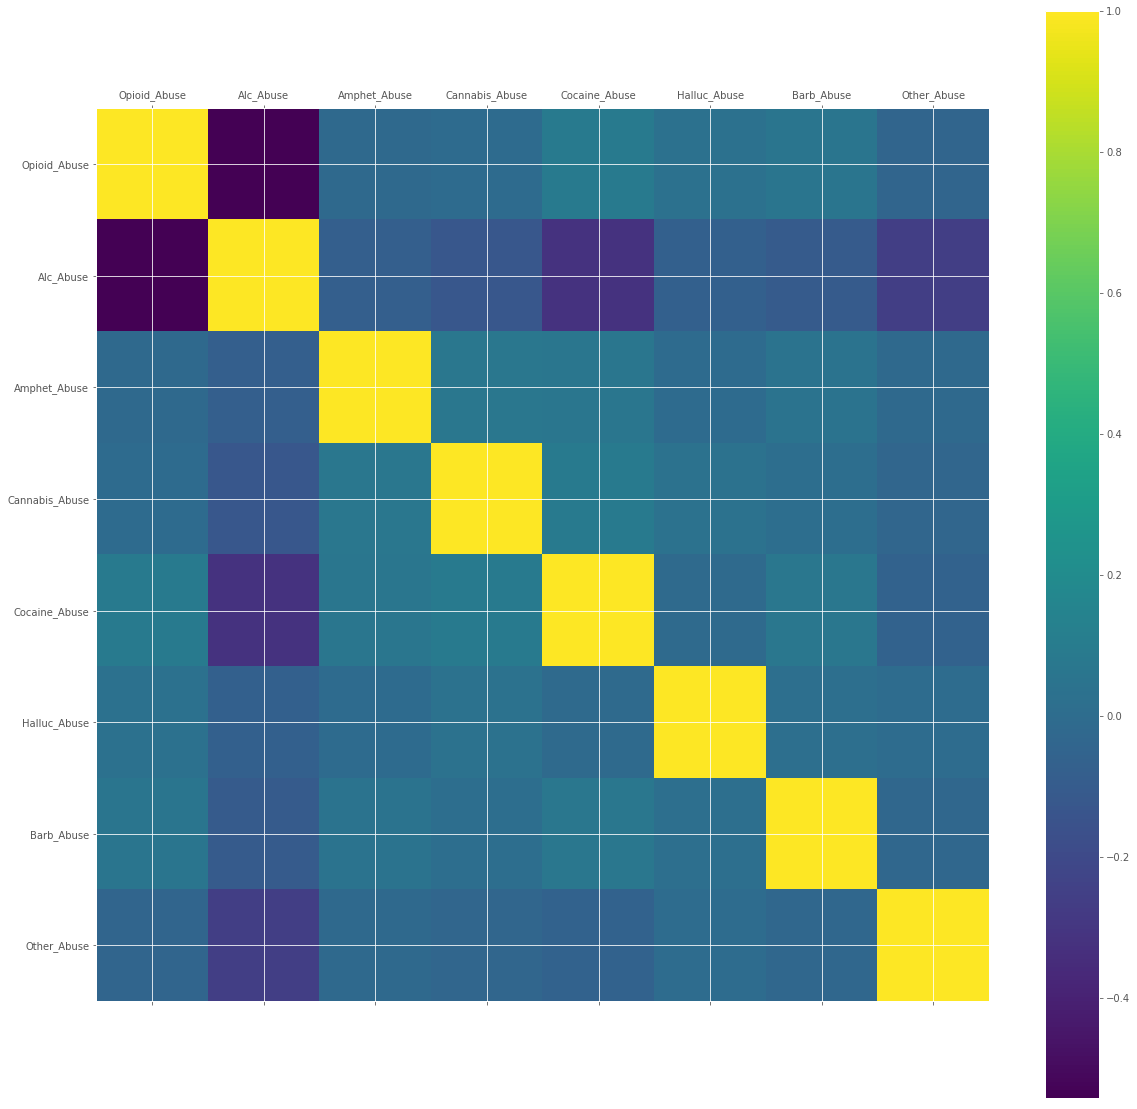

In [28]:
alpha = notes_df.iloc[:,3:].columns.tolist()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(notes_df.iloc[:,3:].corr())
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [29]:
more_than1_count = 0
for i in range(len(notes_df)):
    if(sum(notes_df.iloc[i,3:]) > 1):
        more_than1_count += 1

In [30]:
more_than1_count/len(notes_df)

0.1776885696175787

Text(0.5, 1.0, 'Multiple Drug Diagnoses Vs Single Drug Diagnoses')

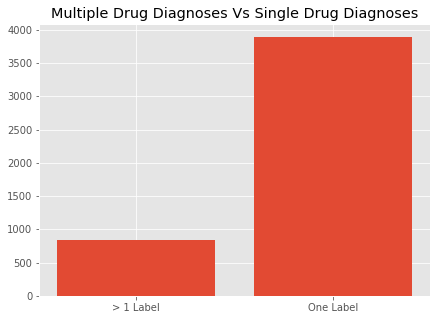

In [31]:
plt.figure(figsize=(7,5))
plt.bar(['> 1 Label', 'One Label'], height=[more_than1_count, len(notes_df)-more_than1_count])
plt.title('Multiple Drug Diagnoses Vs Single Drug Diagnoses')

# Classification

## Random Forrest

https://scikit-learn.org/stable/modules/tree.html#tree-multioutput this explains the multioutput method, leaves predict more than one class, split on lowest entropy for each label.

In [32]:
notes_df = pd.concat([notes_df,no_drugs], ignore_index=True, axis = 0)
notes_df = notes_df[['SUBJECT_ID', 'HADM_ID', 'TEXT','Alc_Abuse', 'Amphet_Abuse', 'Barb_Abuse', 'Cannabis_Abuse',
       'Cocaine_Abuse','Halluc_Abuse', 'Opioid_Abuse',
       'Other_Abuse']]
notes_df.fillna(0, inplace=True)

In [33]:
len(notes_df)

4873

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, hamming_loss
np.random.seed(46)

/Users/benfox/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
# since the classes are unbalanced, find the class weights -> classes are unbalanced but also multilabeled,
#so is weighting useful? Also accuracy and f measure are smaller with weighted classes
from sklearn.utils.class_weight import compute_class_weight
def calculating_class_weights(y_true):
    number_dim = 8
    weights = []
    for i in range(number_dim):
        weights.append(dict(zip([0,1],compute_class_weight('balanced', [0,1], y_true.iloc[:, i]))))
    return weights

In [36]:
weights = calculating_class_weights(notes_df.iloc[:,3:])

In [37]:
notes_df.fillna(0, inplace=True)

In [38]:
test = notes_df.sample(frac= .2) # create test set
notes_df.drop(test.index, inplace = True)

In [39]:
# # max_df -> corpus specific stop words, ignore terms that appear in more than x% of documents,
# # min_df -> ignore terms that appear in less than x% of documents
# # what are the best for these two options? There are likely a lot of corpus specific stop words...
# corp_stop = np.arange(0.1, 1, 0.1)
# stop_max_acc ={}
# stop_max_f = {}

# for i in corp_stop:
#     tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', max_df = i)
#     tf_x_train = tfidf_vectorizer.fit_transform(notes_df.TEXT)
#     rf_clf = RandomForestClassifier(n_estimators = 50, class_weight=weights)
#     rf_clf.fit(tf_x_train, notes_df.iloc[:,3:])
#     test_x_tfidf = tfidf_vectorizer.transform(test.TEXT)
#     rf_predictions = rf_clf.predict(test_x_tfidf)
#     stop_max_acc[i] = accuracy_score(test.iloc[:,3:],rf_predictions)
#     stop_max_f[i] = f1_score(test.iloc[:,3:],rf_predictions, average='micro')
#     print(i)

In [40]:
# stop_min_acc ={}
# stop_min_f = {}

# for i in corp_stop:
#     tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', min_df = i)
#     tf_x_train = tfidf_vectorizer.fit_transform(notes_df.TEXT)
#     rf_clf = RandomForestClassifier(n_estimators=50, class_weight=weights)
#     rf_clf.fit(tf_x_train, notes_df.iloc[:,3:])
#     test_x_tfidf = tfidf_vectorizer.transform(test.TEXT)
#     rf_predictions = rf_clf.predict(test_x_tfidf)
#     stop_min_acc[i] = accuracy_score(test.iloc[:,3:],rf_predictions)
#     stop_min_f[i] = f1_score(test.iloc[:,3:],rf_predictions, average='micro')
#     print(i)

In [95]:
stop_max_acc

{0.1: 0.7642934196332255,
 0.2: 0.7642934196332255,
 0.30000000000000004: 0.761596548004315,
 0.4: 0.7610571736785329,
 0.5: 0.7669902912621359,
 0.6: 0.7653721682847896,
 0.7000000000000001: 0.7637540453074434,
 0.8: 0.7669902912621359,
 0.9: 0.7669902912621359}

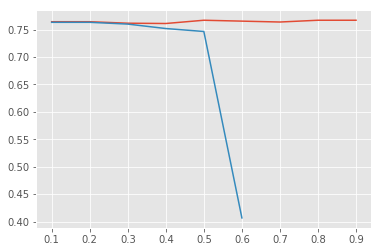

In [92]:
plt.plot(stop_max_acc.keys(),stop_max_acc.values())
plt.plot(stop_min_acc.keys(),stop_min_acc.values())

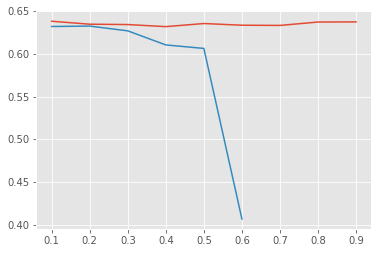

In [93]:
plt.plot(stop_max_f.keys(),stop_max_f.values())
plt.plot(stop_min_f.keys(),stop_min_f.values())

In [44]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', max_df = 0.8, min_df = 0.1)

In [45]:
tf_x_train = tfidf_vectorizer.fit_transform(notes_df.TEXT)

In [46]:
# # best number of trees for random forest
# min_tree = 1
# max_tree = 100
# oob_error = {}
# for i in range(min_tree, max_tree+1):
#     rf_clf = RandomForestClassifier(n_estimators=i, class_weight=weights, oob_score=True)
#     rf_clf.fit(tf_x_train, notes_df.iloc[:,3:])
#     oob_error[i] = 1 - rf_clf.oob_score_
#     print(i)


In [135]:
#oob_error.get(min(oob_error.values()))

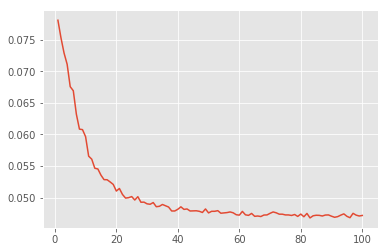

In [131]:
plt.plot(oob_error.keys(),oob_error.values())

In [47]:
rf_clf = RandomForestClassifier(n_estimators=80, class_weight=weights)

In [48]:
rf_clf.fit(tf_x_train, notes_df.iloc[:,3:])

RandomForestClassifier(bootstrap=True,
            class_weight=[{0: 1.903515625, 1: 0.6781241302532702}, {0: 0.5041382164287193, 1: 60.9125}, {0: 0.5124079915878023, 1: 20.64830508474576}, {0: 0.517413463580378, 1: 14.856707317073171}, {0: 0.5805337145580176, 1: 3.6042899408284024}, {0: 0.5012343139271754, 1: 203.04166666666666}, {0: 0.6039910758552305, 1: 2.904052443384982}, {0: 0.5331509846827134, 1: 8.041254125412541}],
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [49]:
test_x_tfidf = tfidf_vectorizer.transform(test.TEXT)

In [50]:
rf_predictions = rf_clf.predict(test_x_tfidf)

In [51]:
rf_acc = accuracy_score(test.iloc[:,3:],rf_predictions)
rf_f1 = f1_score(test.iloc[:,3:],rf_predictions, average='micro')
recall = recall_score(test.iloc[:,3:],rf_predictions, average='micro')
prec = precision_score(test.iloc[:,3:],rf_predictions, average='micro')
rf_hamming_loss = hamming_loss(test.iloc[:,3:],rf_predictions)

In [52]:
rf_acc, rf_f1, recall, prec, rf_hamming_loss

(0.5958974358974359,
 0.6631828978622328,
 0.613896218117854,
 0.7210743801652892,
 0.0908974358974359)

In [53]:
# find important features
feature_indices = np.argsort(rf_clf.feature_importances_)[::-1]

In [54]:
top_ind = []
for f in range(25):
    top_ind.append(feature_indices[f])

In [55]:
imp_feat = []
for i,j in tfidf_vectorizer.vocabulary_.items():
    if j in top_ind:
        imp_feat.append(i)

In [56]:
from wordcloud import WordCloud

In [57]:
imp_feat = [i.replace(' ', '_') for i in imp_feat]

In [58]:
imp_feat

['sedat',
 'heent',
 'small',
 'extrem',
 'secondari',
 'confus',
 'ra',
 'heroin',
 'use',
 'one_capsul',
 'home_discharg_diagnosi',
 'typeart',
 'event',
 'take_medic',
 'tox',
 'mthdoneneg',
 'appearclear_last',
 'serum',
 'name_urin',
 'clear_auscult_bilater',
 'club_cyanosi_edema',
 'primari_care',
 'bnzodzpnneg',
 'bnzodzpnneg_barbitrtneg',
 'acetmnphnneg_bnzodzpnneg_barbitrtneg']

In [59]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 20).generate(' '.join(imp_feat)) 

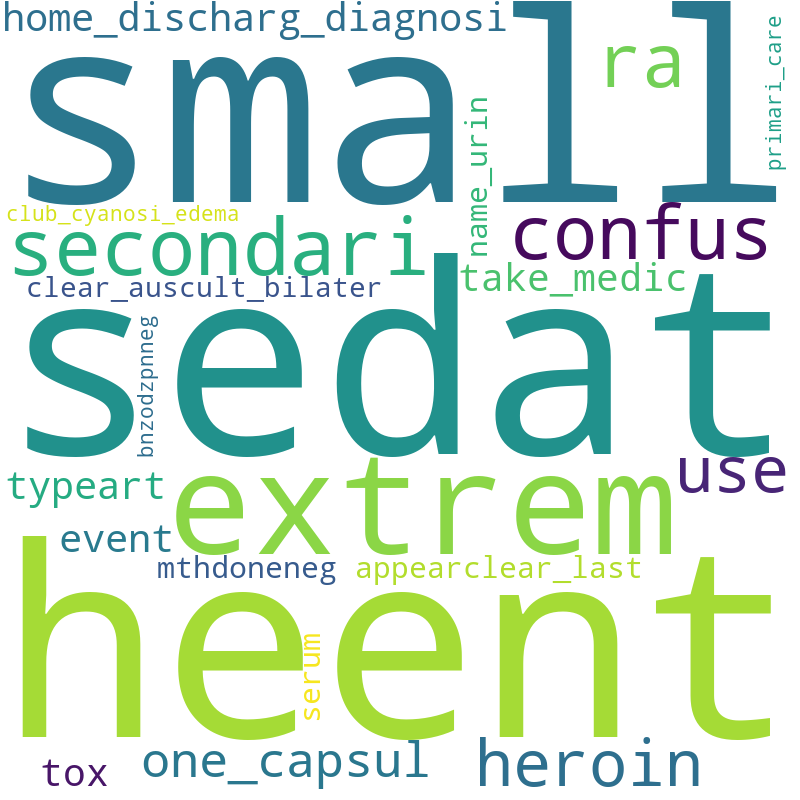

In [60]:
wordcloud.to_image()

### Classifier Chain with Logistic Regression, Random Forest, Naive Bayes

A classifier chain learns L different classifiers and preserves correlation. It essentially learns the first classifier, then using the output from the previous classifier and the feature vectors, trains another classifier for the next label in the set of labels L.

In [151]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [152]:
log_cc_classifier = ClassifierChain(LogisticRegression())
log_cc_classifier.fit(tf_x_train, notes_df.iloc[:,3:])
rf_cc_classifier = ClassifierChain(RandomForestClassifier(n_estimators=35))
rf_cc_classifier.fit(tf_x_train, notes_df.iloc[:,3:])
nb_cc_classifier = ClassifierChain(MultinomialNB())
nb_cc_classifier.fit(tf_x_train, notes_df.iloc[:,3:])

ClassifierChain(base_estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        cv=None, order=None, random_state=None)

In [153]:
log_cc_predictions = log_cc_classifier.predict(test_x_tfidf)
rf_cc_predictions = rf_cc_classifier.predict(test_x_tfidf)
nb_cc_predictions = nb_cc_classifier.predict(test_x_tfidf)

In [154]:
cc_pred = [log_cc_predictions,rf_cc_predictions,nb_cc_predictions]
labels = ['LogReg', 'Random Forest', 'Naive Bayes']
cc_acc = {}
cc_f = {}
for i,j in enumerate(cc_pred):
    cc_acc[labels[i]] = accuracy_score(test.iloc[:,3:], j)
    cc_f[labels[i]] = f1_score(test.iloc[:,3:],j, average='micro')

Text(0.5, 1.0, 'Accuracy and F Measure for Different Classifier Chains')

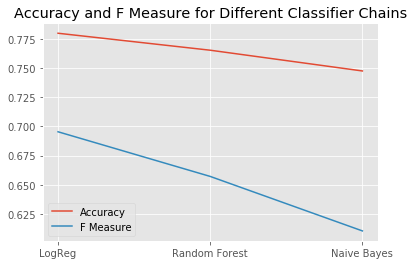

In [155]:
# plot the differences in accuracy and f measure for each classifier chain...
plt.plot(cc_acc.keys(),cc_acc.values(), label = 'Accuracy')
plt.plot(cc_f.keys(),cc_f.values(), label = 'F Measure')
plt.legend()
plt.title('Accuracy and F Measure for Different Classifier Chains')

In [156]:
cc_acc, cc_f

({'LogReg': 0.7799352750809061,
  'Naive Bayes': 0.7475728155339806,
  'Random Forest': 0.7653721682847896},
 {'LogReg': 0.6953966699314398,
  'Naive Bayes': 0.610337972166998,
  'Random Forest': 0.6570862239841427})

### Label Powerset with Logistic Regression

The label powerset method recognizes all possible label combinations as different classes and trains on that. 

In [157]:
from skmultilearn.problem_transform import LabelPowerset

In [158]:
lg_lp_classifier = LabelPowerset(LogisticRegression())
lg_lp_classifier.fit(tf_x_train, notes_df.iloc[:,3:])
rf_lp_classifier = LabelPowerset(RandomForestClassifier(n_estimators=35))
rf_lp_classifier.fit(tf_x_train, notes_df.iloc[:,3:])
nb_lp_classifier = LabelPowerset(MultinomialNB())
nb_lp_classifier.fit(tf_x_train, notes_df.iloc[:,3:])

LabelPowerset(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       require_dense=[True, True])

In [159]:
lg_lp_predictions = lg_lp_classifier.predict(test_x_tfidf)
rf_lp_predictions = rf_lp_classifier.predict(test_x_tfidf)
nb_lp_predictions = nb_lp_classifier.predict(test_x_tfidf)

In [160]:
lp_pred = [lg_lp_predictions,rf_lp_predictions,nb_lp_predictions]
lp_acc = {}
lp_f = {}
for i,j in enumerate(lp_pred):
    lp_acc[labels[i]] = accuracy_score(test.iloc[:,3:], j)
    lp_f[labels[i]] = f1_score(test.iloc[:,3:],j, average='micro')

Text(0.5, 1.0, 'Accuracy and F Measure for Different Classifiers with Label Powerset')

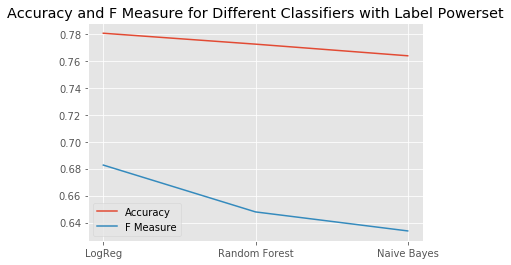

In [161]:
# plot the differences in accuracy and f measure for each label powerset...
plt.plot(lp_acc.keys(),lp_acc.values(), label = 'Accuracy')
plt.plot(lp_f.keys(),lp_f.values(), label = 'F Measure')
plt.legend()
plt.title('Accuracy and F Measure for Different Classifiers with Label Powerset')

How many unique combinations (or classes) were there? 

In [162]:
len(lg_lp_classifier.unique_combinations_)

58

In [163]:
lp_acc, lp_f

({'LogReg': 0.7804746494066882,
  'Naive Bayes': 0.7637540453074434,
  'Random Forest': 0.7723840345199569},
 {'LogReg': 0.6826462128475552,
  'Naive Bayes': 0.6337960746768788,
  'Random Forest': 0.6479007633587787})

### MLKNN

In [164]:
# need to initialize less sparse tfidf matrix for this to work
mlknn_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', max_df = 0.95, min_df = 0.05)
ml_knn_tf_x_train = mlknn_tfidf_vectorizer.fit_transform(notes_df.TEXT)
mlknn_test_x_tfidf = mlknn_tfidf_vectorizer.transform(test.TEXT)

In [165]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

In [166]:
knn_x_train = lil_matrix(ml_knn_tf_x_train).toarray()
knn_y_train = lil_matrix(notes_df.iloc[:,3:]).toarray()
knn_x_test = lil_matrix(mlknn_test_x_tfidf).toarray()

In [167]:
knn_x_train.shape, knn_x_test.shape

((7415, 2051), (1854, 2051))

In [ ]:
parameters = {'k': [5,7,9], 's': [0.5, 0.7, 1.0]}

clf_knn = GridSearchCV(MLkNN(), parameters, scoring='accuracy')
clf_knn.fit(knn_x_train, knn_y_train)

print (clf_knn.best_params_, clf_knn.best_score_)

In [ ]:
clf_knn.best_params_

In [168]:
ml_knn = MLkNN(k=5, s=0.5)
ml_knn.fit(knn_x_train, knn_y_train)

MLkNN(ignore_first_neighbours=0, k=5, s=0.5)

In [169]:
mlknn_predictions = ml_knn.predict(knn_x_test)

In [170]:
mlknn_acc = accuracy_score(test.iloc[:,3:], mlknn_predictions)
mlknn_f1 = f1_score(test.iloc[:,3:],mlknn_predictions, average='micro')#, labels=test.iloc[:,3:].columns)

In [171]:
mlknn_acc, mlknn_f1

(0.7400215749730313, 0.6497507929315814)

In [ ]:
joblib.dump(clf_knn, 'MLKNN_Model')

In [ ]:
ml_knn = joblib.load('MLKNN_Model')

### LSTM

In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

In [195]:
max_features = 20000
max_length = 200
batch_size = 32

tokenizer = Tokenizer(num_words = 5000, split = ' ')
tokenizer.fit_on_texts(notes_df.TEXT)
#print(tokenizer.word_index) # view word index

X = tokenizer.texts_to_sequences(notes_df.TEXT)
X = pad_sequences(X, maxlen = max_length)

model = Sequential()
model.add(Embedding(max_features, 128, input_length = max_length))   
model.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,692,616
Trainable params: 2,692,616
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, notes_df.iloc[:,3:], test_size = 0.2, random_state = 46)
history = model.fit(X_train, Y_train, class_weight=weights, batch_size = batch_size, epochs = 2, validation_split=0.1,  verbose = 1, shuffle=True)

/Users/benfox/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5338 samples, validate on 594 samples
Epoch 1/2
5338/5338 [==============================] - 91s 17ms/step - loss: 0.2212 - categorical_accuracy: 0.8606 - val_loss: 0.1424 - val_categorical_accuracy: 0.8889
Epoch 2/2
5338/5338 [==============================] - 95s 18ms/step - loss: 0.1487 - categorical_accuracy: 0.8606 - val_loss: 0.1336 - val_categorical_accuracy: 0.8721


In [197]:
score = model.evaluate(X_test, Y_test, verbose = 1, batch_size=batch_size)

1483/1483 [==============================] - 4s 3ms/step


In [199]:
lstm_predictions = model.predict(X_test,batch_size=batch_size)

In [200]:
for i in lstm_predictions:
    for j in range(len(i)):
        if i[j] >= 0.5:
            i[j] = 1
        else:
            i[j] = 0

In [201]:
lstm_f1 = f1_score(Y_test,lstm_predictions, average='micro')#, labels=test.iloc[:,3:].columns)

In [202]:
lstm_f1

0.6274007682458386

In [ ]:
model.save('lstm_model.h5') # save model

In [61]:
#history.history

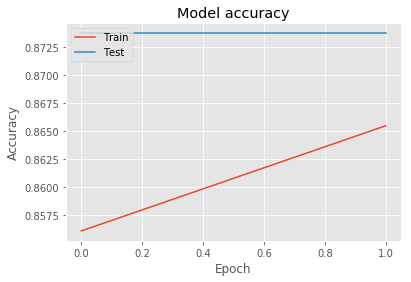

In [176]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [65]:
from keras.models import load_model

In [66]:
model = tf.keras.models.load_model('lstm_model.h5')

/Users/benfox/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [67]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

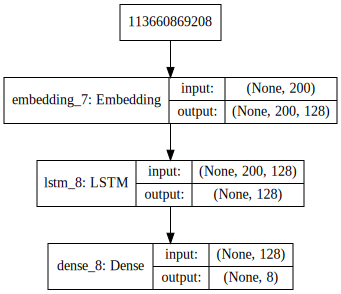

In [68]:
SVG(model_to_dot(model,show_layer_names=True,rankdir=True,show_shapes=True).create(prog='dot', format='svg'))

# Clustering

In [203]:
from sklearn.cluster import KMeans

In [ ]:
for i in range(11, 21):
    k_means = KMeans(n_clusters = i, init= 'k-means++')
    k_means.fit(tf_x_train)
    k_means_dict[i] = k_means.inertia_
    print(i)

In [ ]:
plt.plot(k_means_dict.keys(),k_means_dict.values())

In [204]:
k_means = KMeans(n_clusters = 5, init= 'k-means++')
k_means.fit(tf_x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [205]:
order_centroids = k_means.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()

In [206]:
cluster_terms = {}
for i in range(5):
    x=[]
    for ind in order_centroids[i, :1000]:
        x.append(terms[ind])
    cluster_terms[i] = x

In [207]:
notes_kmeans = notes_df.iloc[:,3:]

In [208]:
notes_kmeans['Cluster'] = k_means.labels_

In [209]:
notes_kmeans = notes_kmeans.groupby('Cluster').sum()

In [210]:
notes_kmeans['Cluster Words'] = cluster_terms

In [211]:
notes_kmeans['Cluster Words']

Cluster
0    0
1    1
2    2
3    3
4    4
Name: Cluster Words, dtype: int64

In [212]:
cluster_themes_dict = {}

for key in cluster_terms.keys():
    current_tfidf = TfidfVectorizer(max_df=0.5)
    current_tfs = current_tfidf.fit_transform(cluster_terms[key])
    
    current_tf_idfs = dict(zip(current_tfidf.get_feature_names(), current_tfidf.idf_))
    tf_idfs_tuples = current_tf_idfs.items()
    cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1])[:5]    

In [213]:
cluster_themes_dict

{0: [('tablet', 4.293777133041319),
  ('blood', 4.6992422411494825),
  ('discharg', 4.786253618139113),
  ('sig', 4.881563797943437),
  ('one', 5.169245870395218)],
 1: [('tablet', 4.293777133041319),
  ('blood', 4.6992422411494825),
  ('discharg', 4.786253618139113),
  ('sig', 4.881563797943437),
  ('one', 5.169245870395218)],
 2: [('tablet', 4.293777133041319),
  ('blood', 4.6992422411494825),
  ('discharg', 4.786253618139113),
  ('sig', 4.881563797943437),
  ('one', 5.169245870395218)],
 3: [('tablet', 4.293777133041319),
  ('blood', 4.6992422411494825),
  ('discharg', 4.786253618139113),
  ('sig', 4.881563797943437),
  ('one', 5.169245870395218)],
 4: [('tablet', 4.293777133041319),
  ('blood', 4.6992422411494825),
  ('discharg', 4.786253618139113),
  ('sig', 4.881563797943437),
  ('one', 5.169245870395218)]}

# Word2Vec

In [1]:
from gensim.models import Word2Vec, keyedvectors

In [ ]:
! pip install glove_python

In [ ]:
y = Word2Vec(notes_df.TEXT, window = 3)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
embed_train_df = notes_orig.TEXT.sample(frac = 0.5)

In [ ]:
embed_sentences = embed_train_df.progress_apply(lambda x: tokenize_mimic(x))

In [ ]:
import pickle

In [ ]:
embed_sentences = pd.read_pickle('embed_sentences')

In [ ]:
model = Word2Vec(embed_sentences.values.tolist())

In [ ]:
model.wv.save_word2vec_format('word2vec_model.bin')

In [2]:
model = keyedvectors.Word2VecKeyedVectors.load_word2vec_format('word2vec_model.bin')

In [3]:
words = list(model.wv.vocab)

/Users/benfox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [4]:
X = model[model.wv.vocab]

/Users/benfox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components = 3)

In [7]:
Y = pca.fit_transform(X)

In [154]:
words_drug = model.most_similar(['drug','abus'],topn=50)

/Users/benfox/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [155]:
temp=[]
for i in words_drug:
    temp.append(model.most_similar([i[0]],topn=10))

/Users/benfox/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [156]:
flat_temp = [j[0] for i in temp for j in i]

In [157]:
for i in words_drug:
    flat_temp.append(i[0])

In [158]:
flat_temp = np.unique(flat_temp).tolist()

In [165]:
flat_temp

['abous',
 'abstain',
 'abus',
 'abuseetoh',
 'addict',
 'alchol',
 'alcohol',
 'alochol',
 'amphetamin',
 'anonym',
 'architect',
 'artist',
 'auschwitz',
 'banker',
 'bartend',
 'bing',
 'bookkeep',
 'cannabinoid',
 'carpent',
 'chef',
 'cigar',
 'cigarrett',
 'cirohosi',
 'cirrhiosi',
 'cirrhosisev',
 'cirrhosispancreat',
 'cirrhosistelemetri',
 'cirrhosistip',
 'cirrhossi',
 'cirrohosi',
 'cirroshi',
 'cirrosi',
 'clerk',
 'cocain',
 'coccain',
 'cocian',
 'coingest',
 'consupt',
 'counselor',
 'cystourethrographi',
 'depressionetoh',
 'detox',
 'detoxif',
 'disput',
 'domest',
 'drawal',
 'drawl',
 'drinker',
 'ecstasi',
 'electrician',
 'employ',
 'engin',
 'eoth',
 'ethanol',
 'ethyl',
 'etoh',
 'exsmok',
 'firefight',
 'gasric',
 'hairdress',
 'hallucinosi',
 'herbal',
 'heroin',
 'historybut',
 'homosexu',
 'hotlin',
 'housewif',
 'ilicit',
 'illeg',
 'illicit',
 'illict',
 'ingest',
 'injest',
 'intox',
 'intranas',
 'isopropanol',
 'isopropyl',
 'ivda',
 'ivdu',
 'librarian'

In [170]:
wc = WordCloud(width = 800, height = 800, background_color ='white', max_words=200, min_font_size = 20).generate(' '.join(flat_temp))

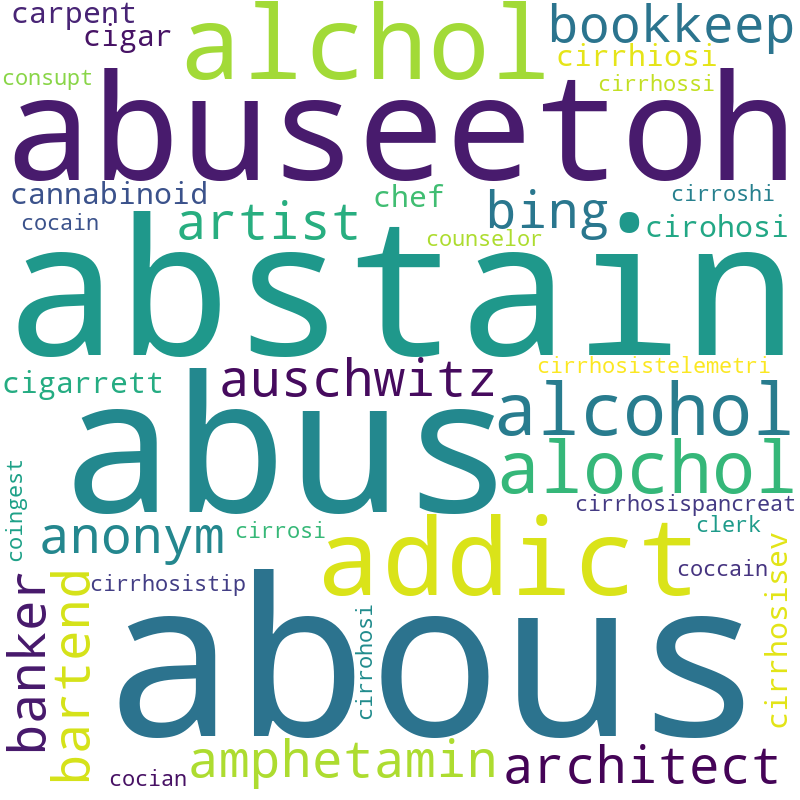

In [171]:
wc.to_image()

In [151]:
indexx =[]
for i in flat_temp:
    indexx.append(words.index(i))

In [152]:
len(Y[indexx,1])

57

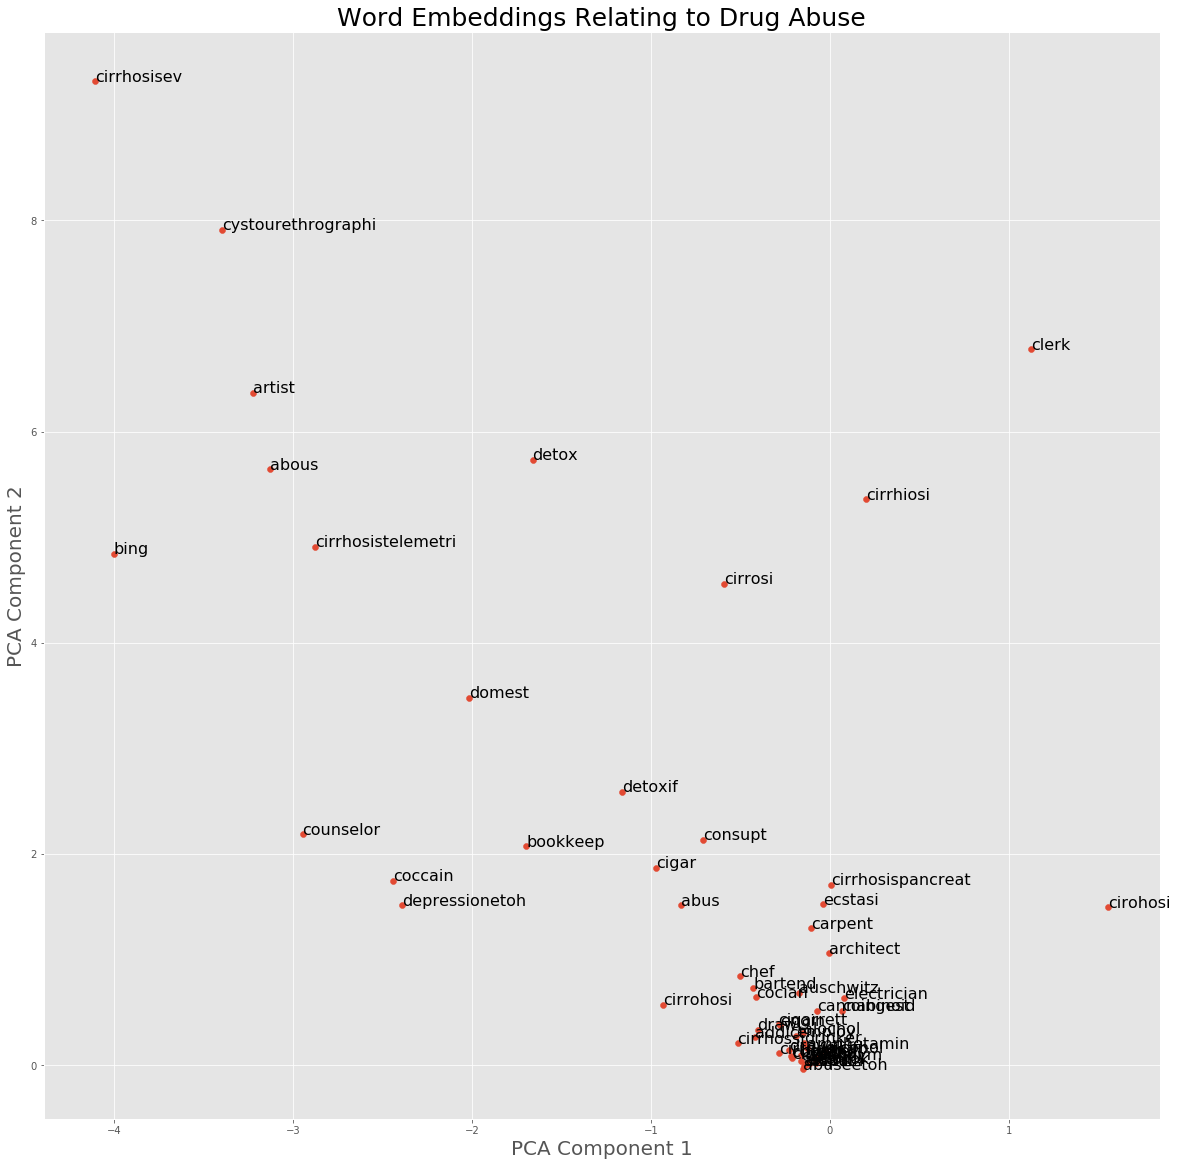

In [174]:
plt.figure(figsize=(20,20))
plt.scatter(Y[indexx, 0], Y[indexx, 1])
for i,y in zip(flat_temp,indexx):
    #print(i,y)
    plt.annotate(i, xy=(Y[y, 0], Y[y, 1]), size = 16)
plt.title('Word Embeddings Relating to Drug Abuse', size = 25)
plt.xlabel('PCA Component 1',size = 20)
plt.ylabel('PCA Component 2',size = 20)
plt.show()